# Milestone Project 1: Food Vision Big

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Check GPU
> We are going to use mixed-precision training which uses GPUs with Compute Capabilities of 8.0 or higher
> The `Tesla T4` that we're using is compatible

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e9b30c20-69e3-12d3-b54c-9c9d09a6ac3e)


Import helper functions

In [2]:
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
import helper_functions
dir(helper_functions)

--2023-09-04 00:33:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-04 00:33:42 (96.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'accuracy_score',
 'calculate_results',
 'compare_historys',
 'confusion_matrix',
 'create_tensorboard_callback',
 'datetime',
 'itertools',
 'load_and_prep_image',
 'make_confusion_matrix',
 'np',
 'os',
 'plot_loss_curves',
 'plt',
 'precision_recall_fscore_support',
 'pred_and_plot',
 'tf',
 'unzip_data',
 'walk_through_dir',
 'zipfile']

In [3]:
from helper_functions import load_and_prep_image, plot_loss_curves, create_tensorboard_callback, walk_through_dir, compare_historys

## Use TensorFlow datasets to download data
https://www.tensorflow.org/datasets/catalog/overview#all_datasets

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # includes labels for supervised learning
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteDSCIVM/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteDSCIVM/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

## Visualising training data

* Class names
* Image shape
* Convert to `tensor` (already done for `tfds`)
* Data type
* Labels (`Label Encoding` or `One-Hot Encoding`)

In [ ]:
one_train = train_data.take(1)
one_train #samples are in the format (image_tensor, label)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


        Shape: (512, 512, 3)
        Datatype: <dtype: 'uint8'>
        Label: 23
        Class Name: churros
        


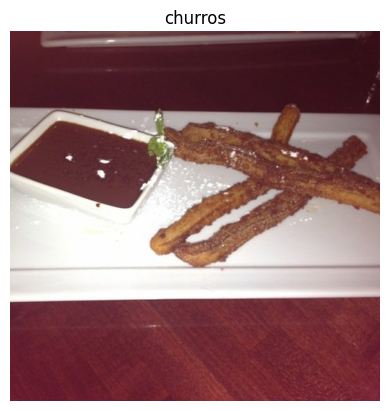

In [ ]:
import matplotlib.pyplot as plt

for image, label in one_train:
  print(f'''
        Shape: {image.shape}
        Datatype: {image.dtype}
        Label: {label}
        Class Name: {class_names[label.numpy()]}
        ''')
  plt.imshow(image)
  plt.axis(False)
  plt.title(class_names[label.numpy()])

In [ ]:
image #tensor form of image, but we need to scale our data!

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 54,  14,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       ...,

       [[108,  31,  49],
        [106,  29,  47],
        [105,  28,  46],
        ...,
        [121,  38,  56],
        [122,  39,  59],
        [123,  40,  60]],

       [[107,  30,  48],
        [107,  30,  48],
        [107,  30,  48],
        ...,
        [121,  38,  58],
        [123,  40,  60],
        [123,  40,  60]],

       [[106,  29,  47],
        [108,  31,  49],
        [109,  32,  50],
        ...,
        [123,  40,  6

Things we need to change
* Shape `(224, 224)`
* Dtype `float32` instead of `uint8` (`float16` or `float32` for `Mixed-Precision` training)
* Scale to `1/255.` (unless you're using an `EfficientNet` model)

## Creating preprocessing functions for our dataset
1. Reshape images to same size (`(224, 224)`)
2. Convert the `dtype` of our images to `float32`

In [4]:
def preprocess_img(image, label, img_shape=224):
  """
  Converts:
  - Image dtype to float32
  - Image shape to (img_shape, img_shape, color_channels)
  """

  resized_image = tf.image.resize(image, [img_shape, img_shape])
  resized_image = tf.cast(resized_image, dtype=tf.float32)
  return resized_image, label

In [ ]:
preprocess_img(image, label)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[ 93.      ,  34.      ,  40.      ],
         [ 94.      ,  35.      ,  41.      ],
         [ 95.      ,  36.      ,  42.      ],
         ...,
         [ 55.      ,  15.      ,  24.      ],
         [ 52.      ,  15.      ,  23.      ],
         [ 52.      ,  15.      ,  23.      ]],
 
        [[ 93.92857 ,  34.928574,  40.928574],
         [ 93.07143 ,  34.071426,  40.071426],
         [ 94.      ,  35.      ,  41.      ],
         ...,
         [ 55.      ,  15.      ,  24.      ],
         [ 54.      ,  14.      ,  23.      ],
         [ 52.      ,  15.      ,  23.      ]],
 
        [[ 93.928566,  35.357143,  41.57143 ],
         [ 91.64285 ,  33.071426,  39.285713],
         [ 91.78571 ,  33.214287,  39.428574],
         ...,
         [ 54.      ,  14.      ,  23.      ],
         [ 55.      ,  15.      ,  24.      ],
         [ 55.      ,  15.      ,  24.      ]],
 
        ...,
 
        [[108.01023 ,  31.010233

## Batch and prepare datasets
- `tf.keras.preprocessing.image_dataset_from_directory` was used previously
- `tf.data.AUTOTUNE` >> Speeding up the preprocessing (`parallelizing`): https://www.tensorflow.org/datasets/performances
- `prefetch` >> while a batch of `tensors` is being computed by the GPU, the batching preparation is done by the GPU


In [ ]:
# Map preprocessing function to training data (and parallelize)

#tf.data.AUTOTUNE uses as much computing power as it can find -> makes processing faster
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data, turn it into batches, and prefetch it (loads faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


# Map preprocessing function to test data (and parallelize)

test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

test_data = test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling `Callbacks`
* TensorBoard >> to log training results
* ModelCheckpoint >> to save model's progress after feature extraction
* EarlyStopping >> to stop training once training has plateaued (good for large datasets)



In [ ]:
# Create tensorboard callback
ckpt_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path,
                                                      monitor="val_accuracy",
                                                      save_weights_only=True,
                                                      save_best_only=True)

## Setup `Mixed Precision Training`
Mixed precision uses a combination of `float16` and `float32` data types to speed up model performance
> Calculation is done in `float16` but numerical storage is done in `float32`
- https://www.tensorflow.org/guide/mixed_precision

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") #sets global data policy to float16

## Create a `Feature Extraction` model using `Transfer Learning`

In [ ]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Activation
from tensorflow.keras import Sequential, Model
INPUT_SHAPE = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = Input(shape=INPUT_SHAPE, name="input_layer")

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D(name="pooling_layer")(x)
x = Dense(len(class_names))(x)
outputs = Activation("softmax", dtype=tf.float32, name="output_layer")(x)

model = Model(inputs, outputs)

# Compile model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 6,048,693
Trainable params: 129,381
Non-trainab

In [ ]:
#Checking layer dtype policies: Are we using mixed precision?

for layer in model.layers:
  print(f'{layer.name} DTYPE: {layer.dtype} DTYPE policy: {layer.dtype_policy}')
  print()

input_layer DTYPE: float32 DTYPE policy: <Policy "float32">

efficientnetv2-b0 DTYPE: float32 DTYPE policy: <Policy "mixed_float16">

pooling_layer DTYPE: float32 DTYPE policy: <Policy "mixed_float16">

dense DTYPE: float32 DTYPE policy: <Policy "mixed_float16">

output_layer DTYPE: float32 DTYPE policy: <Policy "float32">



Notice how the data is stored as float32, but computed (policy) in mixed_float16?

In [ ]:
# Checking our base_model
for layer in model.layers[1].layers:
  print(f'{layer.name} DTYPE: {layer.dtype} DTYPE policy: {layer.dtype_policy}')
  print()

input_1 DTYPE: float32 DTYPE policy: <Policy "float32">

rescaling DTYPE: float32 DTYPE policy: <Policy "mixed_float16">

normalization DTYPE: float32 DTYPE policy: <Policy "mixed_float16">

stem_conv DTYPE: float32 DTYPE policy: <Policy "mixed_float16">

stem_bn DTYPE: float32 DTYPE policy: <Policy "mixed_float16">

stem_activation DTYPE: float32 DTYPE policy: <Policy "mixed_float16">

block1a_project_conv DTYPE: float32 DTYPE policy: <Policy "mixed_float16">

block1a_project_bn DTYPE: float32 DTYPE policy: <Policy "mixed_float16">

block1a_project_activation DTYPE: float32 DTYPE policy: <Policy "mixed_float16">

block2a_expand_conv DTYPE: float32 DTYPE policy: <Policy "mixed_float16">

block2a_expand_bn DTYPE: float32 DTYPE policy: <Policy "mixed_float16">

block2a_expand_activation DTYPE: float32 DTYPE policy: <Policy "mixed_float16">

block2a_project_conv DTYPE: float32 DTYPE policy: <Policy "mixed_float16">

block2a_project_bn DTYPE: float32 DTYPE policy: <Policy "mixed_float16">


In [ ]:
history_101_feature_ext = model.fit(train_data,
                                    epochs=3,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    validation_steps=int(0.15*len(test_data)),
                                    callbacks=[model_checkpoint,
                                              create_tensorboard_callback(dir_name="training_logs",
                                                                          experiment_name="feature_ext_efficientnet_101")]
                                    )

Saving TensorBoard log files to: training_logs/feature_ext_efficientnet_101/20230903-133751
Epoch 1/3
2368/2368 [==============================] - 241s 93ms/step - loss: 1.7506 - accuracy: 0.5757 - val_loss: 1.1414 - val_accuracy: 0.6999
Epoch 2/3
2368/2368 [==============================] - 218s 90ms/step - loss: 1.2122 - accuracy: 0.6870 - val_loss: 1.0366 - val_accuracy: 0.7230
Epoch 3/3
2368/2368 [==============================] - 201s 83ms/step - loss: 1.0654 - accuracy: 0.7207 - val_loss: 1.0126 - val_accuracy: 0.7315


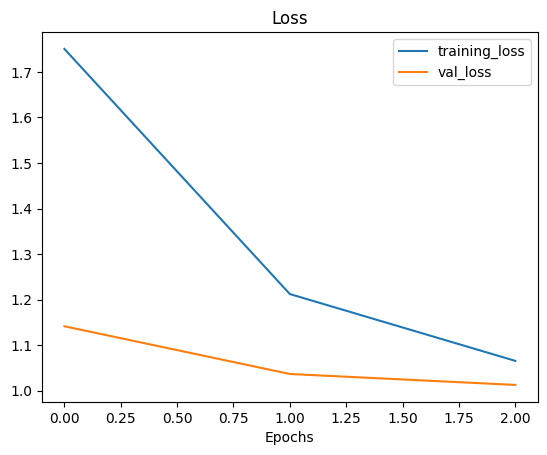

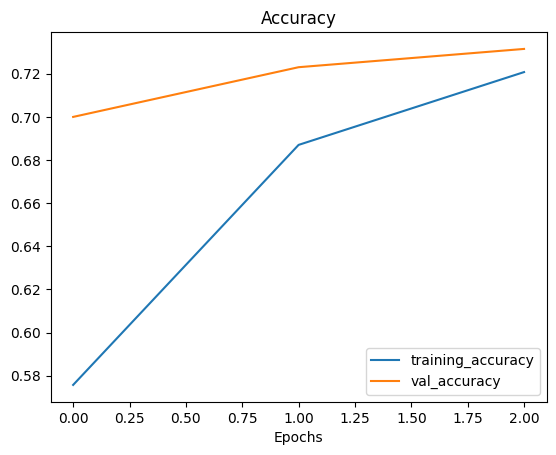

In [ ]:
plot_loss_curves(history_101_feature_ext)

In [ ]:
results_feature_ext = model.evaluate(test_data)
results_feature_ext

790/790 [==============================] - 65s 80ms/step - loss: 0.9989 - accuracy: 0.7299


[0.998867392539978, 0.7298613786697388]

# Food Vision Big (Fine Tuning)
> Goal: Beat the Food101 Paper (77.4% Top-1 accuracy)

In [ ]:
model.save("/drive/MyDrive/model_feature_ext")

In [ ]:
loaded_model = tf.keras.models.load_model("/drive/MyDrive/model_feature_ext")
loaded_model_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 63s 76ms/step - loss: 0.9989 - accuracy: 0.7299


In [ ]:
import numpy as np
np.isclose(loaded_model_results, results_feature_ext)

array([ True,  True])

## `Fine-tune` our base model
We'll set the entire `base_model` to be trainable
> Advisable for a large dataset like `Food101`

In [ ]:
for layer in loaded_model.layers:
  print(f'{layer.name}| Trainable: {layer.trainable}| Policy: {layer.dtype_policy}| Dtype: {layer.dtype}')

input_layer| Trainable: True| Policy: <Policy "float32">| Dtype: float32
efficientnetv2-b0| Trainable: False| Policy: <Policy "mixed_float16">| Dtype: float32
pooling_layer| Trainable: True| Policy: <Policy "mixed_float16">| Dtype: float32
dense| Trainable: True| Policy: <Policy "mixed_float16">| Dtype: float32
output_layer| Trainable: True| Policy: <Policy "float32">| Dtype: float32


In [ ]:
loaded_model.layers[1].trainable = True #index 1 is the base_model

In [ ]:
# Visualise all base_model layers
for layer in loaded_model.layers[1].layers:
  print(f'{layer.name}| Trainable: {layer.trainable}| Policy: {layer.dtype_policy}| Dtype: {layer.dtype}')

input_1| Trainable: True| Policy: <Policy "float32">| Dtype: float32
rescaling| Trainable: True| Policy: <Policy "mixed_float16">| Dtype: float32
normalization| Trainable: True| Policy: <Policy "mixed_float16">| Dtype: float32
stem_conv| Trainable: True| Policy: <Policy "mixed_float16">| Dtype: float32
stem_bn| Trainable: True| Policy: <Policy "mixed_float16">| Dtype: float32
stem_activation| Trainable: True| Policy: <Policy "mixed_float16">| Dtype: float32
block1a_project_conv| Trainable: True| Policy: <Policy "mixed_float16">| Dtype: float32
block1a_project_bn| Trainable: True| Policy: <Policy "mixed_float16">| Dtype: float32
block1a_project_activation| Trainable: True| Policy: <Policy "mixed_float16">| Dtype: float32
block2a_expand_conv| Trainable: True| Policy: <Policy "mixed_float16">| Dtype: float32
block2a_expand_bn| Trainable: True| Policy: <Policy "mixed_float16">| Dtype: float32
block2a_expand_activation| Trainable: True| Policy: <Policy "mixed_float16">| Dtype: float32
block

In [ ]:
## Create `EarlyStopping` Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor="val_accuracy",
                              patience=3,
                              mode="max",
                              restore_best_weights=True,
                              start_from_epoch=2)

model_checkpoint = ModelCheckpoint(filepath="model_checkpoint/fine_tuning.ckpt",
                                   monitor="val_accuracy",
                                   save_best_only=True,
                                   save_weights_only=True)

In [ ]:
loaded_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics=["accuracy"])

In [ ]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 6,048,693
Trainable params: 5,988,085
Non-train

In [ ]:
# Fit the model
initial_epochs = 3
new_epochs = 100
fine_tuned_101_results = loaded_model.fit(train_data,
                                          epochs=new_epochs+initial_epochs,
                                          initial_epoch=initial_epochs,
                                          steps_per_epoch=len(train_data),
                                          validation_data=test_data,
                                          validation_steps=int(0.15*len(test_data)),
                                          callbacks=[model_checkpoint,
                                                     early_stopping,
                                                     create_tensorboard_callback(dir_name="training_logs",
                                                                                 experiment_name="fine_tuned_101_classes_effnet")])

Saving TensorBoard log files to: training_logs/fine_tuned_101_classes_effnet/20230903-141926
Epoch 4/103
2368/2368 [==============================] - 403s 142ms/step - loss: 0.8705 - accuracy: 0.7638 - val_loss: 0.7121 - val_accuracy: 0.8001
Epoch 5/103
2368/2368 [==============================] - 337s 141ms/step - loss: 0.5111 - accuracy: 0.8575 - val_loss: 0.7054 - val_accuracy: 0.8112
Epoch 6/103
2368/2368 [==============================] - 351s 146ms/step - loss: 0.2654 - accuracy: 0.9236 - val_loss: 0.7989 - val_accuracy: 0.8030
Epoch 7/103
2368/2368 [==============================] - 338s 141ms/step - loss: 0.1338 - accuracy: 0.9604 - val_loss: 0.9022 - val_accuracy: 0.7884
Epoch 8/103
2368/2368 [==============================] - 345s 144ms/step - loss: 0.0932 - accuracy: 0.9709 - val_loss: 0.9328 - val_accuracy: 0.8104


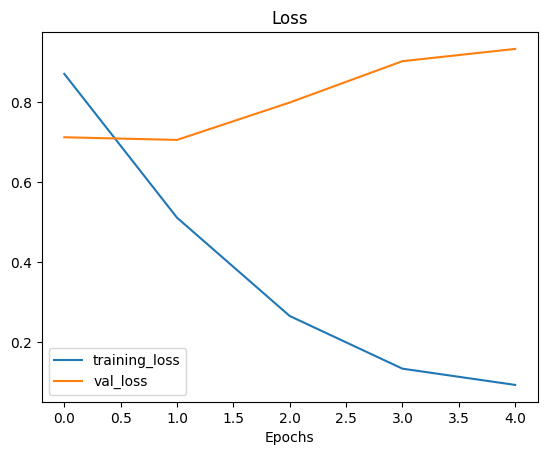

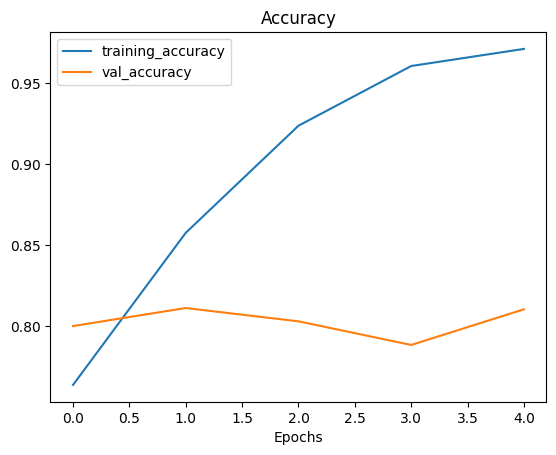

In [ ]:
plot_loss_curves(fine_tuned_101_results)

In [ ]:
fine_tuned_evaluation = loaded_model.evaluate(test_data)

790/790 [==============================] - 65s 80ms/step - loss: 0.7224 - accuracy: 0.8022


In [ ]:
# Saving the model
loaded_model.save("drive/MyDrive/fine_tuned_food101_model")

In [ ]:
!tensorboard dev upload --logdir ./training_logs\
--name  "Fine Tuning for Food101 Classes"\
--description "Use of Fine Tuned Feature Extraction model for 101 Food Classes with 100% of data"\
--one_shot

2023-09-03 14:56:40.460551: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   FMX-NLF-RXM



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe

https://tensorboard.dev/experiment/Xneda2cgTgO1zzfQv69jzg/

## Evaluate model

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds

test_data, ds_info = tfds.load(name="food101",
                                split=["validation"],
                                shuffle_files=True,
                                as_supervised=True, # includes labels for supervised learning
                                with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteQ4DK8J/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteQ4DK8J/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
import tensorflow as tf

class_names = ds_info.features["label"].names
test_data, class_names

([<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>],
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheesecake',
  'cheese_plate',
  'chicken_curry',
  'chicken_quesadilla',
  'chicken_wings',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'clam_chowder',
  'club_sandwich',
  'crab_cakes',
  'creme_brulee',
  'croque_madame',
  'cup_cakes',
  'deviled_eggs',
  'donuts',
  'dumplings',
  'edamame',
  'eggs_benedict',
  'escargots',
  'falafel',
  'filet_mignon',
  'fish_and_chips',
  'foie_gras',
  'french_fries',
  'french_onion_soup',
  'french_toast',
  'fried_calamari',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'greek_salad',
  'grill

In [8]:
fine_tuned_model = tf.keras.models.load_model("/content/drive/MyDrive/fine_tuned_food101_model")

In [9]:
test_data = test_data[0]

In [10]:
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

test_data = test_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
fine_tuned_model_eval = fine_tuned_model.evaluate(test_data)

790/790 [==============================] - 71s 77ms/step - loss: 0.7224 - accuracy: 0.8022


In [12]:
pred_probs = fine_tuned_model.predict(test_data)

790/790 [==============================] - 61s 75ms/step
